# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-HES-ALM/master/main/ds-masters/content/images/hes-logo.png"> CSCI S-89: Introduction to Deep Learning
</br>

**Harvard Summer School**<br/>
**Summer 2024**<br/>
**Instructor**: Dmitry Kurochkin<br/>
**Student**: Artemio Mendoza-García</br>
**Date**: 05/AUG/2024</br>

#### Transfer Learning Notebook (part of the final project)


<hr style="height:2pt">

Note, use Use conda env "s89-finalProject" included in the repository

In [1]:
import os 
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from basicsr.utils.misc import gpu_is_available, get_device
from basicsr.utils.download_util import load_file_from_url
from basicsr.utils.registry import ARCH_REGISTRY
import torch.utils.checkpoint as checkpoint
from torchvision.models import inception_v3
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import gc

In [2]:
# Clear unused memory
torch.cuda.empty_cache()

### PreTrained Model: CodeFormer

In [3]:
device = get_device(1)
print(device)

cuda:1


In [4]:
# Define the model URL
pretrain_model_url = {
    'restoration': 'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/codeformer.pth',
}

# Get Device Configuration 
device = get_device(1)

# Load the CodeFormer model
net = ARCH_REGISTRY.get('CodeFormer')(dim_embd=512, codebook_size=1024, n_head=8, n_layers=9, 
                                      connect_list=['32', '64', '128', '256']).to(device)
# Load the pre-trained weights
ckpt_path = load_file_from_url(url=pretrain_model_url['restoration'], 
                               model_dir='weights/CodeFormer', progress=True, file_name=None)
checkpoint = torch.load(ckpt_path)['params_ema']
net.load_state_dict(checkpoint)
net.eval()

/tmp/ipykernel_852042/2628159038.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)['params_ema']


CodeFormer(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1-2): 2 x ResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Downsample(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      )
      (4): ResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_out): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (5): ResBlock(
        (norm1): GroupNorm(32, 128, eps

### Modify Model for Transfer Learning

In [5]:
# Freeze all layers in encoder and quantizer
for param in net.encoder.parameters():
    param.requires_grad = False

for param in net.quantize.parameters():
    param.requires_grad = False 

# Unfreeze the generator layers (optionally we can fine-tune specific layers)
for param in net.generator.parameters():
    param.requires_grad = True

### Prepare DataLoaders

In [6]:
# Custom Dataset class to load images from specified paths
class CelebADataset(Dataset):
    def __init__(self, clean_dir, noisy_dir, transform=None, num_images=None):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.transform = transform
        self.clean_images = sorted(os.listdir(clean_dir))[:num_images]
        self.noisy_images = sorted(os.listdir(noisy_dir))[:num_images]

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_img_path = os.path.join(self.clean_dir, self.clean_images[idx])
        noisy_img_path = os.path.join(self.noisy_dir, self.noisy_images[idx])

        clean_image = Image.open(clean_img_path).convert("RGB")
        noisy_image = Image.open(noisy_img_path).convert("RGB")

        if self.transform:
            clean_image = self.transform(clean_image)
            noisy_image = self.transform(noisy_image)

        return noisy_image, clean_image

In [7]:
# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [8]:
# Local path with the dataset CELEBA
CELEBA_IMAGE_PATH = "/home/artexmg/d/CELEBA/img_align_celeba/"
# Local path to save noisy images
NOISY_IMAGE_PATH = "/home/artexmg/d/CELEBA/noisy_images/"
num_images = 100 #10000

# Ensure the paths exist and there are enough images
if not os.path.exists(CELEBA_IMAGE_PATH):
    raise FileNotFoundError(f"CELEBA_IMAGE_PATH does not exist: {CELEBA_IMAGE_PATH}")
if not os.path.exists(NOISY_IMAGE_PATH):
    raise FileNotFoundError(f"NOISY_IMAGE_PATH does not exist: {NOISY_IMAGE_PATH}")

#### Load CelebA dataset

In [9]:
# Load the CelebA dataset
dataset = CelebADataset(
    clean_dir=CELEBA_IMAGE_PATH,
    noisy_dir=NOISY_IMAGE_PATH,
    transform=transform,
    num_images=num_images
)

#### Split dataset

In [10]:
# Split dataset into training and validation sets
val_size = int(0.2 * num_images)  # 20% for validation
train_size = num_images - val_size

In [11]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 8

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

#### Only trainning the Final Layers

In [12]:
# Define loss and optimizer
criterion = nn.MSELoss()  # Using Mean Squared Error loss for image restoration
optimizer = optim.Adam(
    net.generator.parameters(), 
    lr=0.00001 #0.0001
) 

#### Implement custom early stopping callback

In [13]:
# Parameters for early stopping
patience = 5
best_loss = float('inf')
best_epoch = 0
best_weights = None

# Training loop
num_epochs = 30

# Initialize lists to store loss values
train_losses = []
val_losses = []

In [15]:
counter = 0

for epoch in range(num_epochs):
    net.train()
    running_train_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch [{epoch + 1}/{num_epochs}]')
    for i, (noisy_images, clean_images) in progress_bar:
        gc.collect()  # Collect garbage
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(noisy_images)
        
        # Extract the primary output from the tuple
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        loss = criterion(outputs, clean_images)  # Calculate loss
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=running_train_loss / (i + 1))
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    net.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for noisy_images, clean_images in val_loader:
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            
            outputs = net(noisy_images)
            
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            loss = criterion(outputs, clean_images)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    epoch_loss = running_val_loss / len(train_loader)
    # pch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')
    
    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_weights = copy.deepcopy(net.state_dict())
        counter = 0
        best_epoch = epoch
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            print(f'Restoring weights for epoch {best_epoch+1}')
            net.load_state_dict(best_weights)
            break    
        
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

# restore best weight
net.load_state_dict(best_weights)

Epoch [1/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s, loss=0.0225]


Epoch [1/30], Training Loss: 0.022484969906508924, Validation Loss: 0.020444198201100033


Epoch [2/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s, loss=0.0199]


Epoch [2/30], Training Loss: 0.019895233679562807, Validation Loss: 0.018932584052284557


Epoch [3/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0184]


Epoch [3/30], Training Loss: 0.01835657060146332, Validation Loss: 0.018057980264226597


Epoch [4/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0175]


Epoch [4/30], Training Loss: 0.017456754203885795, Validation Loss: 0.01748598987857501


Epoch [5/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s, loss=0.0168]


Epoch [5/30], Training Loss: 0.016825935803353786, Validation Loss: 0.01706315080324809


Epoch [6/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s, loss=0.0164]


Epoch [6/30], Training Loss: 0.01635162755846977, Validation Loss: 0.01674511842429638


Epoch [7/30]: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s, loss=0.016]


Epoch [7/30], Training Loss: 0.01595403701066971, Validation Loss: 0.016542585877080757


Epoch [8/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0156]


Epoch [8/30], Training Loss: 0.015631243120878935, Validation Loss: 0.016318422742187977


Epoch [9/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0154]


Epoch [9/30], Training Loss: 0.015384760219603777, Validation Loss: 0.01620461108783881


Epoch [10/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0152]


Epoch [10/30], Training Loss: 0.015155642479658126, Validation Loss: 0.01610240836938222


Epoch [11/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s, loss=0.0149]


Epoch [11/30], Training Loss: 0.014941555447876453, Validation Loss: 0.015991661076744396


Epoch [12/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s, loss=0.0148]


Epoch [12/30], Training Loss: 0.014750075899064541, Validation Loss: 0.015950033130745094


Epoch [13/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0146]


Epoch [13/30], Training Loss: 0.014552562031894922, Validation Loss: 0.01589648611843586


Epoch [14/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s, loss=0.0144]


Epoch [14/30], Training Loss: 0.014364854246377946, Validation Loss: 0.01582021980235974


Epoch [15/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s, loss=0.0142]


Epoch [15/30], Training Loss: 0.01420957837253809, Validation Loss: 0.01578566711395979


Epoch [16/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0141]


Epoch [16/30], Training Loss: 0.014065023884177208, Validation Loss: 0.015752184204757214


Epoch [17/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0139]


Epoch [17/30], Training Loss: 0.013931940868496894, Validation Loss: 0.015700239067276318


Epoch [18/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0138]


Epoch [18/30], Training Loss: 0.013783945888280868, Validation Loss: 0.015684399132927258


Epoch [19/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0137]


Epoch [19/30], Training Loss: 0.013673377316445112, Validation Loss: 0.015706952350835007


Epoch [20/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s, loss=0.0135]


Epoch [20/30], Training Loss: 0.01354022417217493, Validation Loss: 0.015691206169625122


Epoch [21/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s, loss=0.0134]


Epoch [21/30], Training Loss: 0.013413017988204956, Validation Loss: 0.015619124285876751


Epoch [22/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0133]


Epoch [22/30], Training Loss: 0.013297462649643422, Validation Loss: 0.01562123280018568


Epoch [23/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s, loss=0.0132]


Epoch [23/30], Training Loss: 0.013177008274942637, Validation Loss: 0.015611393998066584


Epoch [24/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s, loss=0.0131]


Epoch [24/30], Training Loss: 0.013061892986297608, Validation Loss: 0.015627031835416954


Epoch [25/30]: 100%|██████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s, loss=0.013]


Epoch [25/30], Training Loss: 0.012962833605706691, Validation Loss: 0.0156187421331803


Epoch [26/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0128]


Epoch [26/30], Training Loss: 0.012846751511096955, Validation Loss: 0.015596619807183743


Epoch [27/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0127]


Epoch [27/30], Training Loss: 0.012745636980980635, Validation Loss: 0.015602206190427145


Epoch [28/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0126]


Epoch [28/30], Training Loss: 0.012637618836015463, Validation Loss: 0.015598741360008717


Epoch [29/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0125]


Epoch [29/30], Training Loss: 0.012538390513509513, Validation Loss: 0.015639566505948704


Epoch [30/30]: 100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s, loss=0.0124]


Epoch [30/30], Training Loss: 0.01243703616783023, Validation Loss: 0.01558189063022534


<All keys matched successfully>

In [17]:
# Save the fine-tuned model
# torch.save(net.state_dict(), './models/codeformer_finetuned_v6.pth')

In [16]:
# Load the saved state dictionary
net.load_state_dict(torch.load('../CodeFormer/models/codeformer_finetuned_v5.pth'))

/tmp/ipykernel_852042/1923236370.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('../CodeFormer/models/codeformer_finetuned_v5.pth'))


<All keys matched successfully>

#### Retrieve SOTA model

In [19]:
# ------------------ set up CodeFormer restorer -------------------
net_sota = ARCH_REGISTRY.get('CodeFormer')(
    dim_embd=512, codebook_size=1024, n_head=8, n_layers=9, 
    connect_list=['32', '64', '128', '256']).to(device)
    
# ckpt_path = 'weights/CodeFormer/codeformer.pth'
ckpt_path = load_file_from_url(url=pretrain_model_url['restoration'], 
                                    model_dir='weights/CodeFormer', progress=True, file_name=None)
checkpoint = torch.load(ckpt_path)['params_ema']
net_sota.load_state_dict(checkpoint)

/tmp/ipykernel_852042/323200356.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)['params_ema']


<All keys matched successfully>

In [21]:
# Plot train and validation losses
def plot_loss(train_losses, val_losses, num_images):
    num_epochs = len(val_losses)
    # Plotting the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss vs. Epoch\n{num_images} images')
    plt.legend()
    plt.grid(True)
    plt.show()

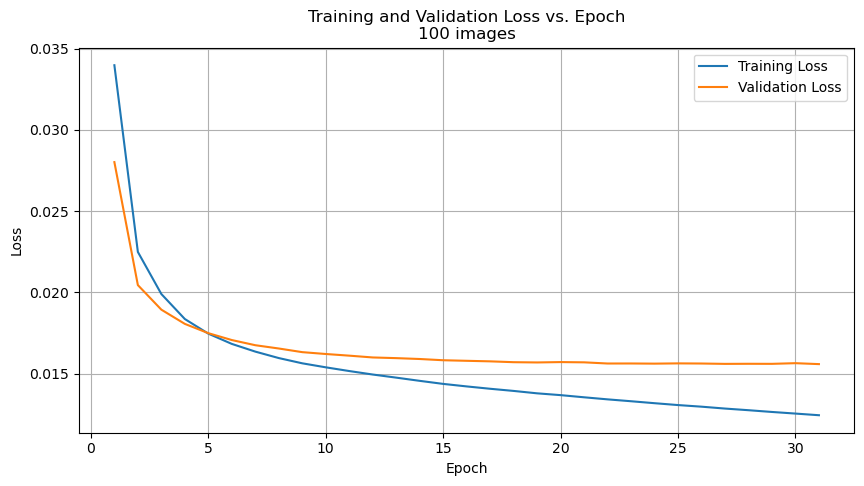

In [22]:
plot_loss(train_losses, val_losses, num_images)

### Image Result Test

In [23]:
# Function to denormalize the image
def denormalize(tensor):
    return tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Predict and save the output
def predict(image_path, output_path, net=net):
    image = load_image(image_path).to(device)
    with torch.no_grad():
        output = net(image)
        if isinstance(output, tuple):
            output = output[0]
    
    output_image = denormalize(output.squeeze().cpu()).clamp(0, 1)  # Remove batch dimension and denormalize
    output_image = transforms.ToPILImage()(output_image)
    output_image.save(output_path)

In [24]:
IMG_SIZE=512

In [25]:
def plot_deblurred(
        image_name,
        input_image_path='./results/test_img_1.0/cropped_faces/', 
        output_image_path="./results/transferLearning",
        IMG_SIZE=512
    ):

    # deblurre image
    input_image_path=os.path.join(input_image_path, image_name)
    output_image_path = os.path.join(output_image_path,image_name)
    predict(input_image_path, output_image_path)
    
    # input image
    noisy_image = cv2.imread(input_image_path)
    noisy_image = cv2.resize(noisy_image, (IMG_SIZE, IMG_SIZE))
    noisy_image = noisy_image.astype('float32')/255.0
    
    # predicted image SOTA
    deblurred_image = cv2.imread(output_image_path)
    deblurred_image = cv2.resize(deblurred_image, (IMG_SIZE, IMG_SIZE))
    deblurred_image = deblurred_image.astype('float32')/255.0

    
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    axs[0].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Blurred Image')
    axs[0].axis('on')

    axs[1].imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Deblurred Image')
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [28]:
def plot_deblurred_all(
        image_name,
        input_image_path='./results/test_img_1.0/cropped_faces/', 
        output_image_path="./results/transferLearning",
        output_sota_path="./results/sota",  
        IMG_SIZE=512
    ):

    # conform paths
    input_image_path=os.path.join(input_image_path, image_name)
    output_image_path = os.path.join(output_image_path,image_name)
    output_sota_path = os.path.join(output_sota_path,image_name)

    # predict deblurred images
    predict(input_image_path, output_image_path, net)
    predict(input_image_path, output_sota_path, net_sota)
    
    # Process input image
    noisy_image = cv2.imread(input_image_path)
    noisy_image = cv2.resize(noisy_image, (IMG_SIZE, IMG_SIZE))
    noisy_image = noisy_image.astype('float32')/255.0
    
    # process predicted image
    deblurred_image = cv2.imread(output_image_path)
    deblurred_image = cv2.resize(deblurred_image, (IMG_SIZE, IMG_SIZE))
    deblurred_image = deblurred_image.astype('float32')/255.0

    # process predicted image
    deblurred_image_sota = cv2.imread(output_sota_path)
    deblurred_image_sota = cv2.resize(deblurred_image_sota, (IMG_SIZE, IMG_SIZE))
    deblurred_image_sota = deblurred_image_sota.astype('float32')/255.0    
    
    fig, axs = plt.subplots(1, 3, figsize=(6, 4))
    axs[0].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Blurred Image')
    axs[0].axis('on')

    axs[1].imshow(cv2.cvtColor(deblurred_image_sota, cv2.COLOR_BGR2RGB))
    axs[1].set_title('SOTA model')
    axs[1].axis('on')

    axs[2].imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Fine Tuned Model')
    axs[2].axis('on')    

    plt.tight_layout()
    plt.show()

In [29]:
def plot_deblurred_sota(
        image_name,
        input_image_path='./results/test_img_1.0/cropped_faces/', 
        output_image_path="./results/transferLearning",
        output_sota_path="./results/sota",  
        IMG_SIZE=512
    ):

    # conform paths
    input_image_path=os.path.join(input_image_path, image_name)
    output_sota_path = os.path.join(output_sota_path,image_name)

    # predict deblurred images
    predict(input_image_path, output_sota_path, net_sota)
    
    # Process input image
    noisy_image = cv2.imread(input_image_path)
    noisy_image = cv2.resize(noisy_image, (IMG_SIZE, IMG_SIZE))
    noisy_image = noisy_image.astype('float32')/255.0

    # process predicted image
    deblurred_image_sota = cv2.imread(output_sota_path)
    deblurred_image_sota = cv2.resize(deblurred_image_sota, (IMG_SIZE, IMG_SIZE))
    deblurred_image_sota = deblurred_image_sota.astype('float32')/255.0    
    
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    axs[0].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Blurred Image')
    axs[0].axis('on')

    axs[1].imshow(cv2.cvtColor(deblurred_image_sota, cv2.COLOR_BGR2RGB))
    axs[1].set_title('SOTA model')
    axs[1].axis('on')  

    plt.tight_layout()
    plt.show()

In [30]:
def plot_deblurred_all(
        image_name,
        input_image_path='./results/test_img_1.0/cropped_faces/', 
        output_image_path="./results/transferLearning",
        output_sota_path="./results/sota",  
        IMG_SIZE=512
    ):

    # conform paths
    input_image_path=os.path.join(input_image_path, image_name)
    output_image_path = os.path.join(output_image_path,image_name)
    output_sota_path = os.path.join(output_sota_path,image_name)

    # predict deblurred images
    predict(input_image_path, output_image_path, net)
    predict(input_image_path, output_sota_path, net_sota)
    
    # Process input image
    noisy_image = cv2.imread(input_image_path)
    noisy_image = cv2.resize(noisy_image, (IMG_SIZE, IMG_SIZE))
    noisy_image = noisy_image.astype('float32')/255.0
    
    # process predicted image
    deblurred_image = cv2.imread(output_image_path)
    deblurred_image = cv2.resize(deblurred_image, (IMG_SIZE, IMG_SIZE))
    deblurred_image = deblurred_image.astype('float32')/255.0

    # process predicted image
    deblurred_image_sota = cv2.imread(output_sota_path)
    deblurred_image_sota = cv2.resize(deblurred_image_sota, (IMG_SIZE, IMG_SIZE))
    deblurred_image_sota = deblurred_image_sota.astype('float32')/255.0    
    
    fig, axs = plt.subplots(1, 3, figsize=(6, 4))
    axs[0].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Blurred Image')
    axs[0].axis('on')

    axs[1].imshow(cv2.cvtColor(deblurred_image_sota, cv2.COLOR_BGR2RGB))
    axs[1].set_title('SOTA model')
    axs[1].axis('on')

    axs[2].imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Fine Tuned Model')
    axs[2].axis('on')    

    plt.tight_layout()
    plt.show()

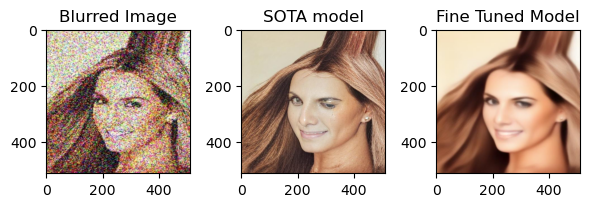

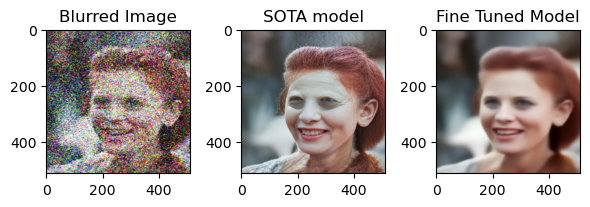

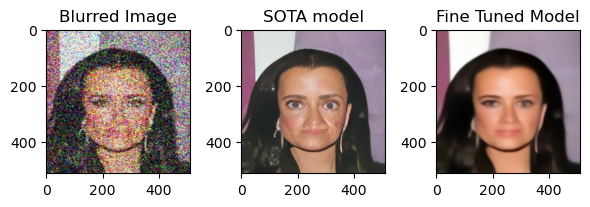

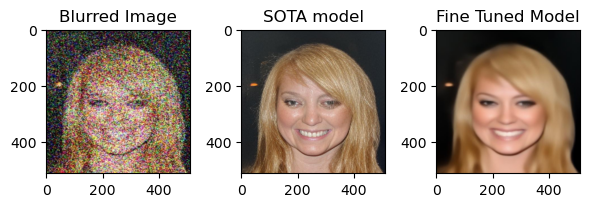

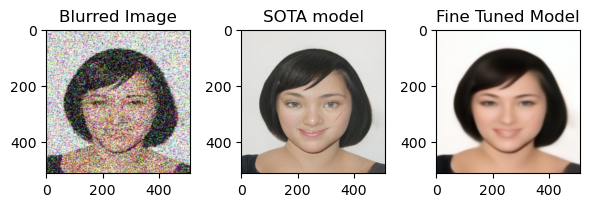

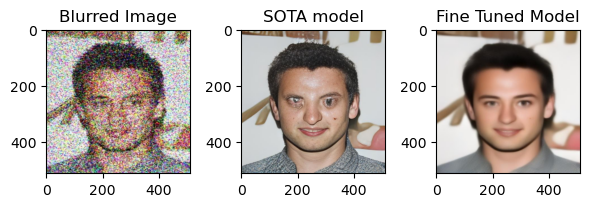

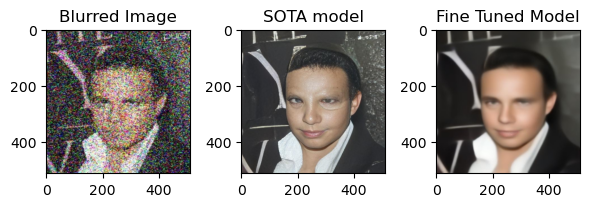

In [71]:
for img_array in ['noisy_000001.jpg','noisy_000002.jpg','noisy_202598.jpg','noisy_000112.jpg','noisy_202593.jpg','noisy_000007.jpg','noisy_000008.jpg']:
    plot_deblurred_all(img_array, NOISY_IMAGE_PATH)

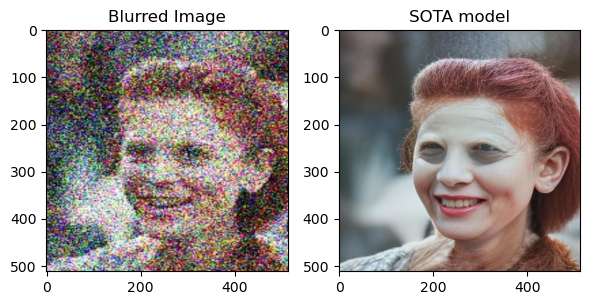

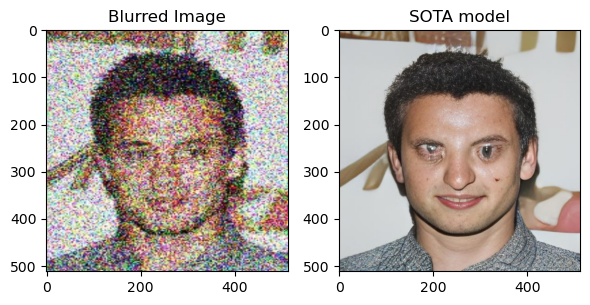

In [76]:
for img_array in ['noisy_000002.jpg','noisy_000007.jpg']:
    plot_deblurred_sota(img_array, NOISY_IMAGE_PATH)

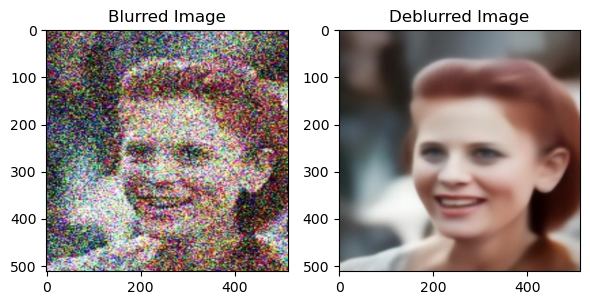

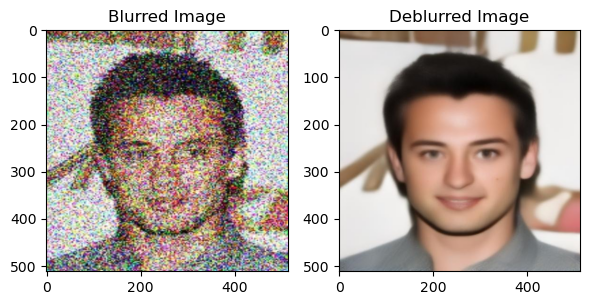

In [74]:
for img_array in ['noisy_000002.jpg','noisy_000007.jpg']:
    plot_deblurred(img_array, NOISY_IMAGE_PATH)

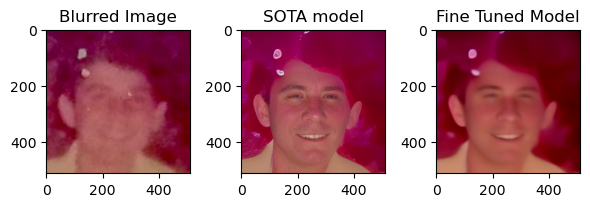

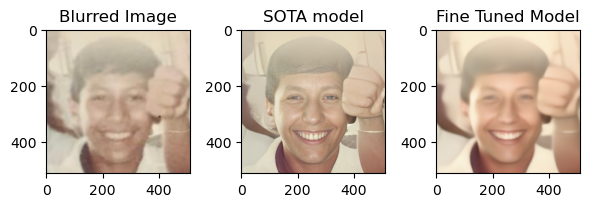

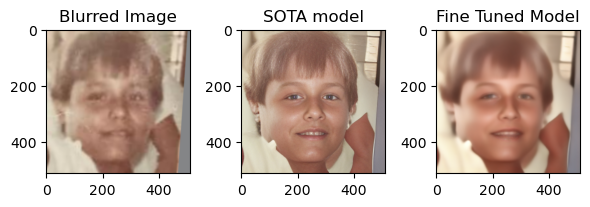

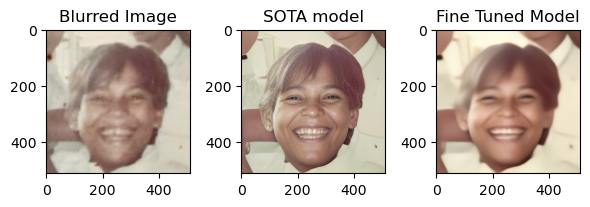

In [37]:
for img_array in ['img001_00.png','img003_00.png','img003_01.png','img003_02.png']:
    plot_deblurred_all(img_array,'./results/test_img_0.7/cropped_faces/') 

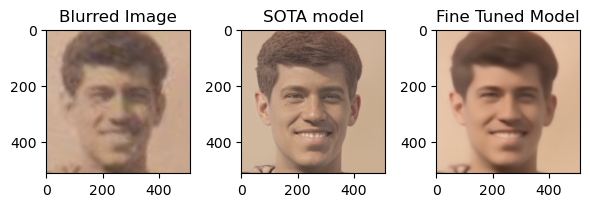

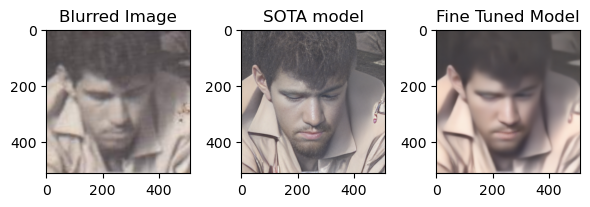

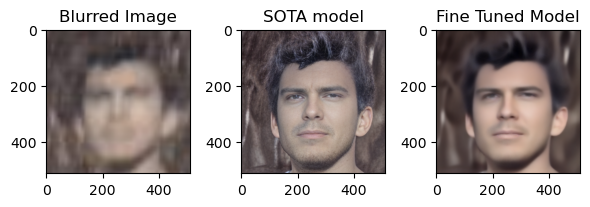

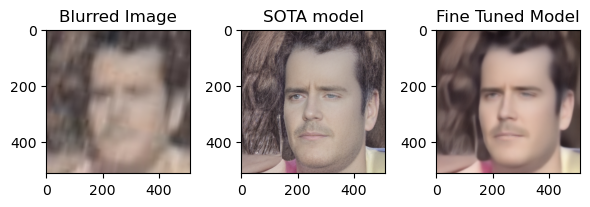

In [38]:
for img_array in ['img004_01.png','img005_01.png','img006_01.png','img006_00.png']:
    plot_deblurred_all(img_array)

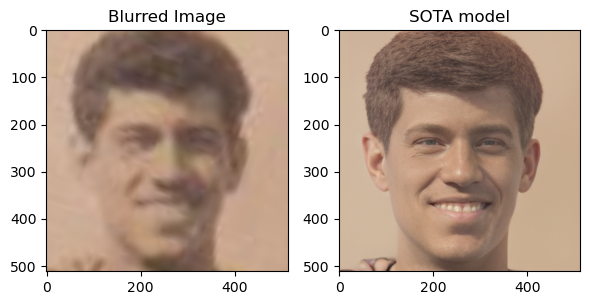

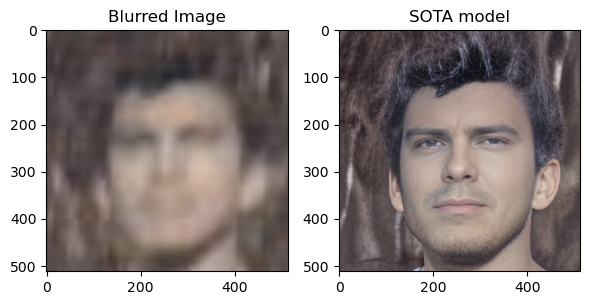

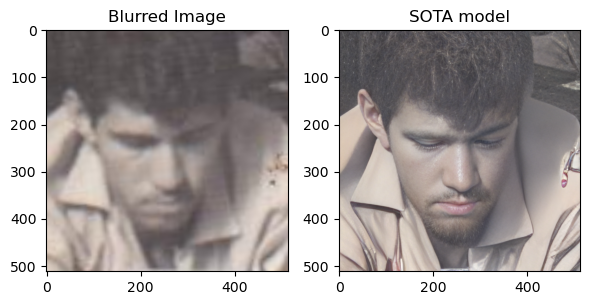

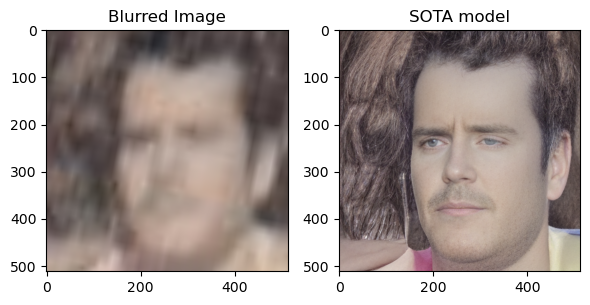

In [79]:
for img_array in ['img004_01.png','img006_01.png','img005_01.png','img006_00.png']:
    plot_deblurred_sota(img_array)

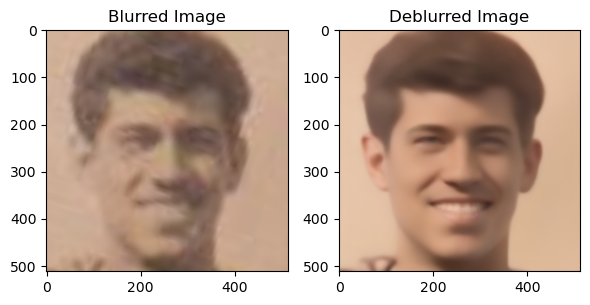

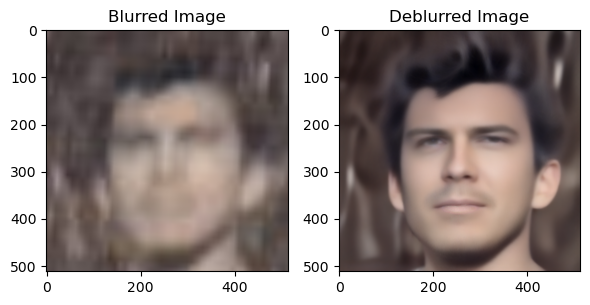

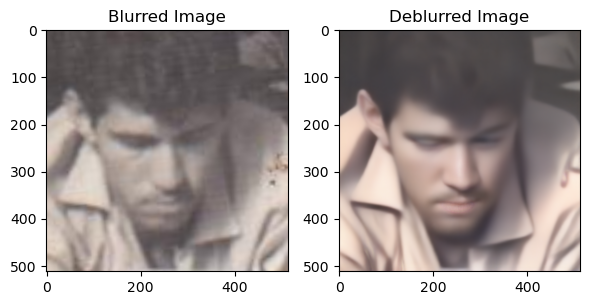

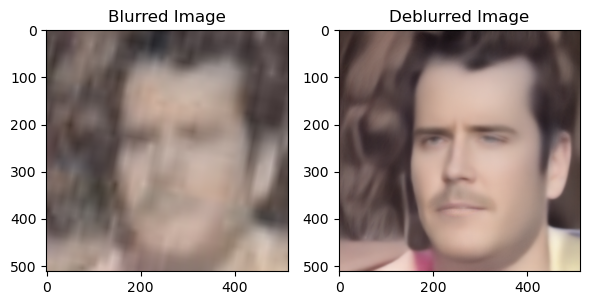

In [78]:
for img_array in ['img004_01.png','img006_01.png','img005_01.png','img006_00.png']:
    plot_deblurred(img_array)

### Final Step: Compute PSNR, SSIM, and FID

In [23]:
import torchmetrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, ToTensor
from torch_fidelity import calculate_metrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

#### Build Test Dataset (unseen images from CelebA)

In [47]:
# Custom Dataset class to load images from specified paths
class CelebATestDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir, transform=None, num_images=None):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.transform = transform
        self.clean_images = sorted(os.listdir(clean_dir))[num_images:num_images*2+1]
        self.noisy_images = sorted(os.listdir(noisy_dir))[num_images:num_images*2+1]

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_img_path = os.path.join(self.clean_dir, self.clean_images[idx])
        noisy_img_path = os.path.join(self.noisy_dir, self.noisy_images[idx])

        clean_image = Image.open(clean_img_path).convert("RGB")
        noisy_image = Image.open(noisy_img_path).convert("RGB")

        if self.transform:
            clean_image = self.transform(clean_image)
            noisy_image = self.transform(noisy_image)

        return noisy_image, clean_image

In [48]:
# Load testDAtaset for CelebA
test_dataset = CelebATestDataset(
    clean_dir=CELEBA_IMAGE_PATH,
    noisy_dir=NOISY_IMAGE_PATH,
    transform=transform,
    num_images=num_images
)

In [49]:
# Create DataLoaders
batch_size = 8

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

#### Compute Metrics

In [50]:
# Function to compute PSNR
def compute_psnr(img1, img2):
    return peak_signal_noise_ratio(img1, img2)

# Function to compute SSIM with specified win_size and data_range
def compute_ssim(img1, img2, win_size=3, data_range=1.0):
    return structural_similarity(img1, img2, multichannel=True, win_size=win_size, data_range=data_range)


In [51]:
def get_metrics(net):
    psnr_list = []
    ssim_list = []
    
    # Prepare lists to store image paths for FID calculation
    real_images_list = []
    fake_images_list = []
    
    with torch.no_grad():
        for i, (noisy_images, clean_images) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            outputs = net(noisy_images)
    
            # Extract the primary output from the tuple if necessary
            if isinstance(outputs, tuple):
                outputs = outputs[0]
    
            for j in range(outputs.size(0)):
                clean_img_np = clean_images[j].cpu().numpy().transpose((1, 2, 0))
                output_img_np = outputs[j].cpu().numpy().transpose((1, 2, 0))
                
                psnr = compute_psnr(clean_img_np, output_img_np)
                ssim = compute_ssim(clean_img_np, output_img_np, win_size=3, data_range=1.0)
    
                psnr_list.append(psnr)
                ssim_list.append(ssim)
    
                # Save real and fake images for FID calculation
                real_image_path = f'real_images/real_{i}_{j}.png'
                fake_image_path = f'fake_images/fake_{i}_{j}.png'
                
                transforms.ToPILImage()(clean_images[j].cpu()).save(real_image_path)
                transforms.ToPILImage()(outputs[j].cpu()).save(fake_image_path)
                
                real_images_list.append(real_image_path)
                fake_images_list.append(fake_image_path)
    
    # Compute FID using torch-fidelity
    metrics = calculate_metrics(
        input1='real_images',
        input2='fake_images',
        cuda=True,
        isc=False,
        fid=True,
        kid=False
    )
    
    fid_score = metrics['frechet_inception_distance']
    
    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)
    
    print(f'Average PSNR: {avg_psnr:.4f}')
    print(f'Average SSIM: {avg_ssim:.4f}')
    print(f'FID Score: {fid_score:.4f}')


#### Load models (if needed)

In [26]:
# Load our trained Model
if LOAD_MODEL:
    # Load Transfer Learning Model
    net.load_state_dict(torch.load('./models/codeformer_finetuned_v5.pth'))

In [ ]:
# Load the SOTA Model
if LOAD_MODEL:
    # ------------------ set up CodeFormer restorer -------------------
    net_sota = ARCH_REGISTRY.get('CodeFormer')(
        dim_embd=512, codebook_size=1024, n_head=8, n_layers=9, 
        connect_list=['32', '64', '128', '256']).to(device)
        
    # ckpt_path = 'weights/CodeFormer/codeformer.pth'
    ckpt_path = load_file_from_url(url=pretrain_model_url['restoration'], 
                                        model_dir='weights/CodeFormer', progress=True, file_name=None)
    checkpoint = torch.load(ckpt_path)['params_ema']
    net_sota.load_state_dict(checkpoint)

#### Compute Metrics for Transfer Learning model

In [52]:
get_metrics(net)

Processing Batches: 100%|████████████████████████████████████████████████| 1251/1251 [46:14<00:00,  2.22s/it]
Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 10001 samples
Processing samples                                                                                           
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 10001 samples
Processing samples                                                                                           


Average PSNR: 24.6098
Average SSIM: 0.7295
FID Score: 57.7089


Frechet Inception Distance: 57.708886413386836


#### Compute Metrics for SOTA model

In [53]:
get_metrics(net_sota)

Processing Batches: 100%|████████████████████████████████████████████████| 1251/1251 [35:20<00:00,  1.70s/it]
Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 10001 samples
Processing samples                                                                                           
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 10001 samples
Processing samples                                                                                           


Average PSNR: 20.2048
Average SSIM: 0.5517
FID Score: 35.7009


Frechet Inception Distance: 35.700884879823604
